# Imports and Global Variables

In [0]:
!pip install pytorch-ignite

     |████████████████████████████████| 112kB 7.8MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ast import literal_eval
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from scipy import sparse

In [0]:
from ignite.handlers import ModelCheckpoint, EarlyStopping, TerminateOnNan
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

In [0]:
import torch
import torch.nn as nn
from torch import optim
import string
import random
import torch.utils.data as Data

In [0]:
from collections import OrderedDict
import locale
from locale import atof, atoi
locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
use_idf = True
max_features = 2**10
pca_components = 2**4
DRIVE_PATH = Path('/content/drive/My Drive/Thesis2019/')
NEIGHBOURHOOD_PROFILES_PATH = Path('neighbourhood-profiles-2016-csv.csv')
NEIGHBOURHOOD_PROFILES_PATH_OLD = Path('neighbourhood-data-2001-2011.xlsx')
DATA_DIR = DRIVE_PATH.joinpath('data_stripped')
use_cuda = True
years = [2011, 2016]

# Dataset Wrapper

Pytorch Dataset wrappers

In [0]:
class ReviewsVector(Data.Dataset):
    """Reviews Vector dataset."""

    def __init__(self, data):
        """
        Args: 
          data

        """
        self.shape = data.shape
        self.data = torch.tensor(data).type(torch.FloatTensor)
        if use_cuda and torch.cuda.is_available():
          self.data = self.data.cuda()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class CensusVector(Data.Dataset):
  def __init__(self, data, reviews_embedding):
        """
        Args: 
          data

        """
        self.shape = data.shape
        self.data = torch.tensor(data).type(torch.FloatTensor)
        self.reviews_embedding = torch.tensor(reviews_embedding).type(torch.FloatTensor)
        if use_cuda and torch.cuda.is_available():
            self.data = self.data.cuda()
            self.reviews_embedding = self.reviews_embedding.cuda()
            
  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      return {"data": self.data[idx],
              "reviews_embedding": self.reviews_embedding[idx]}

# Data Cleaning and Preprocessing

## Selecting and Matching Attributes for 2011 and 2016 data

Match census categories from different years.

In [0]:
nbh_profiles = pd.read_csv(DRIVE_PATH.joinpath(NEIGHBOURHOOD_PROFILES_PATH))
nbh_profiles_2011 = pd.read_excel(DRIVE_PATH.joinpath(NEIGHBOURHOOD_PROFILES_PATH_OLD), sheet_name='2011')

In [0]:
income_2011 = nbh_profiles_2011[(nbh_profiles_2011['Topic']=='Income of households')].drop(columns=['Category', 'Topic', 'City of Toronto'])
income_2016 = nbh_profiles[(nbh_profiles['Topic']=='Income of households in 2015')].drop(columns=['_id', 'Category', 'Topic', 'Data Source', 'City of Toronto'])

In [0]:
idx_2011 = income_2011[income_2011['Attribute'] == 'Household total income in 2010 of private households'].index
idx_2011_2 = income_2011[income_2011['Attribute'] == 'After-tax income of households in 2010 of private households'].index
income_2011 = income_2011.loc[idx_2011[0]+1:idx_2011_2[0]-1]

In [0]:
idx_2016 = income_2016[income_2016['Characteristic'] == 'Total - Household total income groups in 2015 for private households - 100% data'].index
idx_2016_2 = income_2016[income_2016['Characteristic'] == 'Total - Household after-tax income groups in 2015 for private households - 100% data'].index
idx_2016_3 = income_2016[income_2016['Characteristic'] == '  $15,000 to $19,999'].index

In [0]:
income_2016_1 = income_2016.loc[idx_2016[0]+1:idx_2016_2[0]-1]
income_2016_1.loc[1] = income_2016.loc[idx_2016_3[0]]

income_2016_1 = income_2016.loc[idx_2016[0]+1:idx_2016_2[0]-1]
income_2016_1.loc[1] = income_2016.loc[idx_2016_3[0]]

income_2016 = income_2016_1

In [0]:
list(income_2011['Attribue'])

['  Under $10,000',
 '  $10,000 to $19,999',
 '  $20,000 to $29,999',
 '  $30,000 to $39,999',
 '  $40,000 to $49,999',
 '  $50,000 to $59,999',
 '  $60,000 to $79,999',
 '  $80,000 to $99,999',
 '  $100,000 and over']

In [0]:
list(income_2016['Characteristic'])

['  Under $5,000',
 '  $5,000 to $9,999',
 '  $10,000 to $14,999',
 '  $20,000 to $24,999',
 '  $25,000 to $29,999',
 '  $30,000 to $34,999',
 '  $35,000 to $39,999',
 '  $40,000 to $44,999',
 '  $45,000 to $49,999',
 '  $50,000 to $59,999',
 '  $60,000 to $69,999',
 '  $70,000 to $79,999',
 '  $80,000 to $89,999',
 '  $90,000 to $99,999',
 '  $100,000 and over',
 '    $200,000 and over',
 '  $15,000 to $19,999']

In [0]:
income_2011.set_index('Attribute', inplace=True)

income_2011.loc['  Under $10,000'] = income_2011.loc['  Under $5,000'] + income_2011.loc['  $5,000 to $9,999']
income_2011.loc['  $10,000 to $19,999'] = income_2011.loc['  $10,000 to $14,999'] + income_2011.loc['  $15,000 to $19,999']
income_2011.loc['  $100,000 and over'] = income_2011.loc['  $100,000 to $124,999'] + income_2011.loc['  $125,000 to $149,999'] + income_2011.loc['  $150,000 and over']

income_2011 = income_2011.reindex(['  Under $10,000', '  $10,000 to $19,999', '  $20,000 to $29,999', '  $30,000 to $39,999', 
                     '  $40,000 to $49,999', '  $50,000 to $59,999', '  $60,000 to $79,999', '  $80,000 to $99,999', 
                     '  $100,000 and over'])


In [0]:
income_2016.set_index('Characteristic', inplace=True)
income_2016 = income_2016.applymap(atoi)

income_2016.loc['  Under $10,000'] = income_2016.loc['  Under $5,000'] + income_2016.loc['  $5,000 to $9,999']
income_2016.loc['  $10,000 to $19,999'] = income_2016.loc['  $10,000 to $14,999'] + income_2016.loc['  $15,000 to $19,999']
income_2016.loc['  $20,000 to $29,999'] = income_2016.loc['  $20,000 to $24,999'] + income_2016.loc['  $25,000 to $29,999']
income_2016.loc['  $30,000 to $39,999'] = income_2016.loc['  $30,000 to $34,999'] + income_2016.loc['  $35,000 to $39,999']
income_2016.loc['  $40,000 to $49,999'] = income_2016.loc['  $40,000 to $44,999'] + income_2016.loc['  $45,000 to $49,999']
income_2016.loc['  $60,000 to $79,999'] = income_2016.loc['  $60,000 to $69,999'] + income_2016.loc['  $70,000 to $79,999']
income_2016.loc['  $80,000 to $99,999'] = income_2016.loc['  $80,000 to $89,999'] + income_2016.loc['  $90,000 to $99,999']

income_2016 = income_2016.reindex(['  Under $10,000', '  $10,000 to $19,999', '  $20,000 to $29,999', '  $30,000 to $39,999', 
                     '  $40,000 to $49,999', '  $50,000 to $59,999', '  $60,000 to $79,999', '  $80,000 to $99,999', 
                     '  $100,000 and over'])

In [0]:
income_2011 = income_2011.T.sort_index()
income_2016 = income_2016.T.sort_index()

In [0]:
cleaned = [income_2011, income_2016]

## Build Census datasets

In [0]:
incomes = {}
for income in cleaned:
  incomes[year] = income.div(income.sum(axis=1), axis=0)
  income.to_csv(DRIVE_PATH.joinpath('income_'+str(year)+'.csv'))

## Load Built Census datasets

In [0]:
incomes = {}

for year in years:
  incomes[year] = pd.read_csv(DRIVE_PATH.joinpath('income_{}.csv'.format(year)))
  incomes[year].set_index('Unnamed: 0', inplace=True)

# Predicting Census Change

Census Change prediction is evaluated with Mean Total Absolute Error:

$Mean Total Absolute Error = $

$\frac{1}{\#Neighbourhoods}\sum_{Neighbourhoods} \sum_{categories} |Actual Proportion - Predicted Proportion|$




$categories \in \{\text{No degree, High school diploma, Apprenticeship certificate, College diploma, University certificate below bachelor level, University degree above bachelor level}\}$ 

### Train-test split

Split by neighbourhoods

In [0]:
train_val_neighbourhoods, test_neighbourhoods = train_test_split(range(0, 140), test_size=0.15)

all_trains, all_vals = [], [] #Do random splits to cross validate
folds = 5

for i in range(folds):
  train_neighbourhoods, val_neighbourhoods = train_test_split(train_val_neighbourhoods, test_size=0.30)
  all_trains.append(train_neighbourhoods)
  all_vals.append(val_neighbourhoods)

### Baseline-Predicting no change

In [0]:
dummy_data = incomes[2011].values
actual_data = incomes[2016].values

In [0]:
# Training Error
np.abs(dummy_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.14757192238340344

In [0]:
# Testing Error
np.abs(dummy_data[test_neighbourhoods] - actual_data[test_neighbourhoods]).sum(axis=1).mean()

0.14101081314013955

## TF-IDF Autoencoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, sizes):
        super(Encoder, self).__init__()
                
        layers_en = OrderedDict()       
        for i in range(len(sizes)-1):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_en[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            if i==0:
                nn.init.xavier_uniform_(layers_en[layer_name].weight)
            layers_en[act_name] = nn.Tanh() #-1 to 1
        
        self.encoder = nn.Sequential(layers_en)

    def forward(self, x):
        return self.encoder(x) 
    
class Decoder(nn.Module):
    def __init__(self, sizes):
        super(Decoder, self).__init__()
        
        sizes = sizes[::-1]
        
        layers_de = OrderedDict()
        for i in range(len(sizes)-2):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_de[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            layers_de[act_name] = nn.Tanh()

        layers_de['linear{}'.format(len(sizes)-1)] = nn.Linear(sizes[-2], sizes[-1])
        layers_de['sigmoid'] = nn.Sigmoid() #0 to 1
        self.decoder = nn.Sequential(layers_de)

    def forward(self, encoded):
        return self.decoder(encoded) 

### Load trained model and built csvs

In [0]:
reviews_all = {}
for year in [2011, 2016]:
  reviews_all[year] = pd.read_csv(DRIVE_PATH.joinpath('neighbourhood_reviews_{}.csv'.format(year)))
  reviews_all[year].set_index('Unnamed: 0', inplace=True)

reviews = {}
for year in [2011, 2016]:
  reviews[year] = ReviewsVector(reviews_all[year].T.values)

In [0]:
lr = 0.001
patience = 20
min_lr = 0.00001

In [0]:
sizes_r = [max_features, 2**10, 2**8, pca_components]
encoder = Encoder(sizes_r)
decoder = Decoder(sizes_r)

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [0]:
encoder.load_state_dict(torch.load('/content/drive/My Drive/Thesis2019/models/review_encoder2_500.pth'))
encoder.eval()
encoder.to(torch.device("cuda"))

decoder.load_state_dict(torch.load('/content/drive/My Drive/Thesis2019/models/review_decoder2_500.pth'))
decoder.eval()
decoder.to(torch.device("cuda"))

Decoder(
  (decoder): Sequential(
    (linear1): Linear(in_features=16, out_features=256, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=256, out_features=1024, bias=True)
    (activation2): Tanh()
    (linear3): Linear(in_features=1024, out_features=1024, bias=True)
    (sigmoid): Sigmoid()
  )
)

### Multi-target Linear Regression

In [0]:
from sklearn.linear_model import RidgeCV

In [0]:
lr = RidgeCV(cv=5)
delta_census = incomes[2016].values - incomes[2011].values
delta_embedding = (encoder(reviews[2016].data) - encoder(reviews[2011].data)).detach().cpu().numpy()

In [0]:
lr.fit(delta_embedding[train_val_neighbourhoods], delta_census[train_val_neighbourhoods])

In [0]:
predicted_change = lr.predict(delta_embedding)

In [0]:
# Training Error
np.abs((predicted_change[train_val_neighbourhoods]-delta_census[train_val_neighbourhoods])).sum(axis=1).mean()

0.10074098288154398

In [0]:
# Validation Error
np.abs((predicted_change[test_neighbourhoods]-delta_census[test_neighbourhoods])).sum(axis=1).mean()

0.10321286493590617

### Multi-target Non-Linear Regression (Census Decoder)

In [0]:
class Decoder_C(nn.Module):
    def __init__(self, sizes, softmax=False):
        super(Decoder_C, self).__init__()
        sizes = sizes[::-1]
        layers_de = OrderedDict()

        for i in range(len(sizes)-2):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_de[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            layers_de[act_name] = nn.Tanh()

        layers_de['linear{}'.format(len(sizes)-1)] = nn.Linear(sizes[-2], sizes[-1])
        # layers_de['softmax'] = nn.Softmax(dim=1) # row sum to 1
        layers_de['tanh'] = nn.Tanh()
        if softmax:
          layers_de['softmax'] = nn.Softmax(dim=1)
        self.decoder = nn.Sequential(layers_de)

    def forward(self, encoded):
        return self.decoder(encoded) 

In [0]:
def criterion_c(data, decoded):
    mse_loss = nn.MSELoss()
    loss = mse_loss(data, decoded)
    return loss

In [0]:
def train_decoder(decoder, dataset, train_indices, test_indices, name='edu_2'):
  optimizer_de = optim.Adam(decoder.parameters(), lr=0.001)
  scheduler_de = optim.lr_scheduler.ReduceLROnPlateau(optimizer_de, 'min', patience=20, min_lr=min_lr, factor=0.1)

  def process_function(engine, batch):
    decoder.train()
    optimizer_de.zero_grad()
    decoded = decoder(batch['reviews_embedding'])
    loss = criterion_c(decoded, batch['data'])
    loss.backward()

    optimizer_de.step()
    return loss.item()
  

  def eval_function(engine, batch):
    decoder.eval()

    with torch.no_grad():
        decoded = decoder(batch['reviews_embedding'])
        return decoded, batch['data']
  
  trainer = Engine(process_function)
  train_evaluator = Engine(eval_function)
  validation_evaluator = Engine(eval_function)

  metric = Loss(criterion_c)
  metric.attach(train_evaluator, 'loss')
  metric.attach(validation_evaluator, 'loss')

  training_losses = []
  validation_losses = []

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(engine):
      train_evaluator.run(train_iterator)
      metrics = train_evaluator.state.metrics
      avg_loss = metrics['loss']    
      training_losses.append(avg_loss)
      print("Training Results - Epoch: {}  Avg loss: {:.10f}"
           .format(engine.state.epoch, avg_loss))
      
  def log_validation_results(engine):
      validation_evaluator.run(valid_iterator)
      metrics = validation_evaluator.state.metrics
      avg_loss = metrics['loss']
      validation_losses.append(avg_loss)

      print("Validation Results - Epoch: {}  Avg loss: {:.10f}"
            .format(engine.state.epoch, avg_loss))

  trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

  # Reduce on Plateau
  def average_loss(engine):
    print("Current lr: {}".format(optimizer_de.param_groups[0]['lr']))
    average_loss = engine.state.metrics['loss']
    scheduler_de.step(average_loss)

  validation_evaluator.add_event_handler(Events.COMPLETED, average_loss)
  
  # Early Stopping
  def score_function(engine):
      val_loss = engine.state.metrics['loss']
      return -val_loss

  handler = EarlyStopping(patience=30, score_function=score_function, trainer=trainer)
  validation_evaluator.add_event_handler(Events.COMPLETED, handler)

  # Model Checkpoint
  checkpointer = ModelCheckpoint(str(DRIVE_PATH.joinpath('models')), name, n_saved=1, create_dir=False, save_as_state_dict=True, require_empty=False)
  trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'decoder_c': decoder})

  train_iterator = Data.DataLoader(dataset, batch_size=1, drop_last=False, sampler=Data.SubsetRandomSampler(train_indices))
  valid_iterator = Data.DataLoader(dataset, batch_size=1, drop_last=False, sampler=Data.SubsetRandomSampler(test_indices))

  trainer.run(train_iterator, max_epochs=1000)
  return training_losses, validation_losses

In [0]:
delta_embedding = encoder(reviews[2016].data) - encoder(reviews[2011].data)
delta_census = incomes[2016].values - incomes[2011].values
census_data = CensusVector(delta_census, delta_embedding)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [0]:
sizes_c = [incomes[2011].shape[1], pca_components]
decoder_c = Decoder_C(sizes_c)

if use_cuda and torch.cuda.is_available():
    decoder_c.cuda()

In [0]:
decoder_c

Decoder_C(
  (decoder): Sequential(
    (linear1): Linear(in_features=16, out_features=9, bias=True)
    (tanh): Tanh()
  )
)

In [0]:
validation_losses, training_losses = [], []
for i in range(folds):
  print('FOLD', i)
  t, v = train_decoder(decoder_c, census_data, all_trains[i], all_vals[i])
  training_losses.extend(t)
  validation_losses.extend(v)

FOLD 0
Training Results - Epoch: 1  Avg loss: 0.0052946128
Current lr: 0.001
Validation Results - Epoch: 1  Avg loss: 0.0057191926
Training Results - Epoch: 2  Avg loss: 0.0029022310
Current lr: 0.001
Validation Results - Epoch: 2  Avg loss: 0.0034734008
Training Results - Epoch: 3  Avg loss: 0.0018275210
Current lr: 0.001
Validation Results - Epoch: 3  Avg loss: 0.0024848400
Training Results - Epoch: 4  Avg loss: 0.0013567157
Current lr: 0.001
Validation Results - Epoch: 4  Avg loss: 0.0020110682
Training Results - Epoch: 5  Avg loss: 0.0010867487
Current lr: 0.001
Validation Results - Epoch: 5  Avg loss: 0.0017343459
Training Results - Epoch: 6  Avg loss: 0.0009131554
Current lr: 0.001
Validation Results - Epoch: 6  Avg loss: 0.0015350160
Training Results - Epoch: 7  Avg loss: 0.0007980848
Current lr: 0.001
Validation Results - Epoch: 7  Avg loss: 0.0013765588
Training Results - Epoch: 8  Avg loss: 0.0007130811
Current lr: 0.001
Validation Results - Epoch: 8  Avg loss: 0.0012541503
T

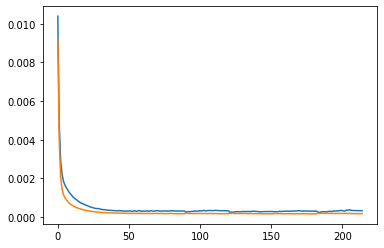

In [0]:
plt.plot(range(len(validation_losses)), validation_losses, range(len(training_losses)), training_losses)
plt.savefig(DRIVE_PATH.joinpath('loss.png'))

In [0]:
# Test Loss
criterion_c(census_data.data[test_neighbourhoods], decoder_c(census_data.reviews_embedding[test_neighbourhoods]))

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
decoded_delta = decoder_c(delta_embedding).cpu().detach().numpy()
actual_data = incomes[2016].values
predicted_data = incomes[2011].values+ decoded_delta

In [0]:
# Training error
np.abs(predicted_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.09893043176503016

In [0]:
# Testing error
np.abs(predicted_data[test_neighbourhoods] - actual_data[test_neighbourhoods]).sum(axis=1).mean()

0.1290547679091938

## ELMO

### Load trained model and built csvs

In [0]:
reviews_elmo_all = {}
reviews_elmo = {}
for year in [2011, 2016]:
  reviews_elmo_all[year] = pd.read_csv(DRIVE_PATH.joinpath('elmo_reviews_{}.csv'.format(year)))
  reviews_elmo_all[year].set_index('Unnamed: 0', inplace=True)
  reviews_elmo[year] = ReviewsVector(reviews_elmo_all[year].T.values)

In [0]:
delta_embedding = reviews_elmo[2016].data.T - reviews_elmo[2011].data.T
delta_census = incomes[2016].values - incomes[2011].values
census_data = CensusVector(delta_census, delta_embedding)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Multi-target Linear Regression

In [0]:
lingreg = RidgeCV(cv=5)
lingreg.fit(delta_embedding[train_val_neighbourhoods].detach().cpu().numpy(), delta_census[train_val_neighbourhoods])

In [0]:
# Training Error
np.abs((predicted_change[train_val_neighbourhoods]-delta_census[train_val_neighbourhoods])).sum(axis=1).mean()

0.09775755647610872

In [0]:
# Testing Error
np.abs((predicted_change[test_neighbourhoods]-delta_census[test_neighbourhoods])).sum(axis=1).mean()

0.10627870847900157

### Multi-target Non-Linear Regression

#### With one layer

In [0]:
lr = 0.001
patience = 20
min_lr = 0.00001

In [0]:
sizes_c = [incomes[2011].shape[1], reviews_elmo_all[2016].shape[1]]
decoder_c = Decoder_C(sizes_c)

if use_cuda and torch.cuda.is_available():
    decoder_c.cuda()

In [0]:
decoder_c

Decoder_C(
  (decoder): Sequential(
    (linear1): Linear(in_features=1024, out_features=9, bias=True)
    (tanh): Tanh()
  )
)

In [0]:
validation_losses, training_losses = [], []
for i in range(folds):
  print('FOLD', i)
  t, v = train_decoder(decoder_c, census_data, all_trains[i], all_vals[i], name='inc_elmo')
  training_losses.extend(t)
  validation_losses.extend(v)

FOLD 0
Training Results - Epoch: 1  Avg loss: 0.0027470749
Current lr: 0.001
Validation Results - Epoch: 1  Avg loss: 0.0017631822
Training Results - Epoch: 2  Avg loss: 0.0033430097
Current lr: 0.001
Validation Results - Epoch: 2  Avg loss: 0.0010259317
Training Results - Epoch: 3  Avg loss: 0.0057298000
Current lr: 0.001
Validation Results - Epoch: 3  Avg loss: 0.0024721965
Training Results - Epoch: 4  Avg loss: 0.0062040288
Current lr: 0.001
Validation Results - Epoch: 4  Avg loss: 0.0011419559
Training Results - Epoch: 5  Avg loss: 0.0042454136
Current lr: 0.001
Validation Results - Epoch: 5  Avg loss: 0.0009794299
Training Results - Epoch: 6  Avg loss: 0.0045418475
Current lr: 0.001
Validation Results - Epoch: 6  Avg loss: 0.0012158749
Training Results - Epoch: 7  Avg loss: 0.0046741401
Current lr: 0.001
Validation Results - Epoch: 7  Avg loss: 0.0008619955
Training Results - Epoch: 8  Avg loss: 0.0050186254
Current lr: 0.001
Validation Results - Epoch: 8  Avg loss: 0.0019986758
T

In [0]:
decoded_delta = decoder_c(delta_embedding).cpu().detach().numpy()
predicted_data = incomes[2011].values + decoded_delta

In [0]:
# Training Error
np.abs(predicted_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.07935540107798843

In [0]:
# Testing Error
np.abs(predicted_data[test_neighbourhoods] - actual_data[test_neighbourhoods]).sum(axis=1).mean()

0.18424671551108865

#### With Additional Layer

In [0]:
sizes_c = [incomes[2011].shape[1], reviews_elmo_all[2016].shape[1]//2, reviews_elmo_all[2016].shape[1]]
decoder_c = Decoder_C(sizes_c)

if use_cuda and torch.cuda.is_available():
    decoder_c.cuda()

In [0]:
decoder_c

Decoder_C(
  (decoder): Sequential(
    (linear1): Linear(in_features=1024, out_features=512, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=512, out_features=9, bias=True)
    (tanh): Tanh()
  )
)

In [0]:
validation_losses, training_losses = [], []
for i in range(folds):
  print('FOLD', i)
  t, v = train_decoder(decoder_c, census_data, all_trains[i], all_vals[i], name='inc_elmo')
  training_losses.extend(t)
  validation_losses.extend(v)

FOLD 0
Training Results - Epoch: 1  Avg loss: 0.0209234761
Current lr: 0.001
Validation Results - Epoch: 1  Avg loss: 0.0137059486
Training Results - Epoch: 2  Avg loss: 0.0118081027
Current lr: 0.001
Validation Results - Epoch: 2  Avg loss: 0.0050664927
Training Results - Epoch: 3  Avg loss: 0.0222936612
Current lr: 0.001
Validation Results - Epoch: 3  Avg loss: 0.0090419727
Training Results - Epoch: 4  Avg loss: 0.0055555309
Current lr: 0.001
Validation Results - Epoch: 4  Avg loss: 0.0012912722
Training Results - Epoch: 5  Avg loss: 0.0079673715
Current lr: 0.001
Validation Results - Epoch: 5  Avg loss: 0.0044263674
Training Results - Epoch: 6  Avg loss: 0.0035997835
Current lr: 0.001
Validation Results - Epoch: 6  Avg loss: 0.0009635887
Training Results - Epoch: 7  Avg loss: 0.0023973171
Current lr: 0.001
Validation Results - Epoch: 7  Avg loss: 0.0008790885
Training Results - Epoch: 8  Avg loss: 0.0016483821
Current lr: 0.001
Validation Results - Epoch: 8  Avg loss: 0.0007659951
T

In [0]:
decoded_delta = decoder_c(delta_embedding).cpu().detach().numpy()
predicted_data = incomes[2011].values + decoded_delta

In [0]:
np.abs(predicted_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.0858662570687752

In [0]:
np.abs(predicted_data[test_neighbourhoods] - actual_data[test_neighbourhoods]).sum(axis=1).mean()

0.131040148882963

## Results Summary

<table>
    <thead>
        <tr>
            <th rowspan=2>Model</th>
            <th rowspan=2> "No change" </th>
            <th colspan=2>TF-IDF Autoencoder</th>
            <th colspan=2>ELMO</th>
        </tr>
        <tr>
            <th>LR</th>
            <th>NLR1</th>
            <th>LR</th>
            <th>NLR1</th>
            <th>NLR2</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Training MAE</td>
            <td>14.76%</td>
            <td>10.07%</td>
            <td>9.89%</td>
            <td>9.78%</td>
            <td>7.94%</td>
            <td>8.59%</td>
        </tr>
        <tr>
            <td>Testing MAE</td>
            <td>14.10%</td>
            <td>10.32%</td>
            <td>12.90%</td>
            <td>10.63%</td>
            <td>18.42%</td>
            <td>13.10%</td>
        </tr>
</tbody>
</table>

## Sensitivity Analysis

Senesitivity Analysis is done on the best performing model, TF-IDF Autoencoder with Linear Regression

In [0]:
def evaluate_dim_reviews(reviews, orig_delta_embedding, dim):
    orig_decoded = lr.predict(orig_delta_embedding)
    diff = np.zeros(orig_decoded.shape)
  
    r_2011 = reviews[2011].data.clone()
    r_2016 = reviews[2016].data.clone()

    r_2011[:, dim] = torch.zeros(r_2011.shape[0])
    r_2016[:, dim] = torch.zeros(r_2016.shape[0])

    delta_embedding = encoder(r_2016) - encoder(r_2011)

    decoded = lr.predict(delta_embedding.detach().cpu().numpy())
    diff = orig_decoded - decoded

    diff = diff.mean(axis=0)
    
    return diff

In [0]:
feature_importance_reviews = np.zeros((reviews[2011].data.shape[1], delta_census.shape[1]))
for i in range(reviews[2011].data.shape[1]):
  feature_importance_reviews[i] = evaluate_dim_reviews(reviews, delta_embedding, i)

In [0]:
# sort by absolute mean
sort_importance = np.argsort(np.abs(feature_importance_reviews).mean(axis=1))[::-1]

In [0]:
with open(DRIVE_PATH.joinpath('models/words.out'), 'r') as f:
  words = f.read().split('\n')

words = words[:-1]

df_importance = pd.DataFrame(feature_importance_reviews, columns=incomes[2011].columns, index=words)

In [0]:
df_importance.columns

Index(['  Under $10,000', '  $10,000 to $19,999', '  $20,000 to $29,999',
       '  $30,000 to $39,999', '  $40,000 to $49,999', '  $50,000 to $59,999',
       '  $60,000 to $79,999', '  $80,000 to $99,999', '  $100,000 and over'],
      dtype='object')

In [0]:
# Low income
df_importance['  Under $10,000'][df_importance['  Under $10,000'].abs().sort_values(ascending=False)[3:13].index]

really good         0.000025
violating           0.000024
customer service   -0.000020
patio              -0.000014
amazing            -0.000014
sales               0.000014
customer           -0.000012
deep fried         -0.000012
fish               -0.000012
sashimi             0.000011
Name:   Under $10,000, dtype: float64

In [0]:
# Mid-level
df_importance['  $50,000 to $59,999'][df_importance['  $50,000 to $59,999'].abs().sort_values(ascending=False)[3:13].index]

violating terms     0.000036
burger             -0.000022
chips              -0.000016
customer service   -0.000015
jerk                0.000014
service            -0.000013
coffee              0.000013
ice cream          -0.000013
pizza              -0.000012
school              0.000011
Name:   $50,000 to $59,999, dtype: float64

In [0]:
# High-income
df_importance['  $100,000 and over'][df_importance['  $100,000 and over'].abs().sort_values(ascending=False)[:10].index]

chicken             0.000032
review removed      0.000020
highly recommend    0.000014
store              -0.000011
sashimi            -0.000011
salmon             -0.000010
school              0.000010
really good        -0.000009
burger             -0.000009
class               0.000008
Name:   $100,000 and over, dtype: float64